In [140]:
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
# import pygeos
import alphashape
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
from descartes import PolygonPatch
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPoint, Point
from shapely.ops import unary_union
from shapely import wkt
# from shapely.plotting import plot_polygon


# Pats

## Read base csv

In [2]:
basedf = pd.read_csv('plots/dbscanpats13/dbscanpats13.csv')
basedf = basedf[~basedf.layer.isin(['0', 'all'])]
# basedf = basedf[basedf.layer.isin(['12', '14'])]
basedf

,layer,pts,ptswgt,epsilon,minden,minpts,n_clusters,pts_clusters,pts_noise,ptswgt_clusters,ptswgt_noise,cluster_share,conc_coeff
1,11,25953,42815.0,15,0.039612,28,157,15197,10756,30198.0,12617.0,0.705314,0.410627
2,12,16530,26067.0,15,0.035368,25,107,8962,7568,17628.0,8439.0,0.676257,0.352515
3,13,39306,96768.0,15,0.074980,53,148,23352,15954,75955.0,20813.0,0.784919,0.569837
4,14,20813,41140.0,15,0.049515,35,109,11289,9524,29945.0,11195.0,0.727880,0.455761
5,21,44788,69541.0,15,0.053759,38,192,28093,16695,49620.0,19921.0,0.713536,0.427072
6,31,31265,48375.0,15,0.036782,26,211,19506,11759,33786.0,14589.0,0.698419,0.396837
7,32,21753,27517.0,15,0.026880,19,164,13157,8596,18169.0,9348.0,0.660283,0.320565
8,33,20508,24990.0,15,0.022635,16,185,12709,7799,16501.0,8489.0,0.660304,0.320608
9,34,30696,41979.0,15,0.031124,22,216,19047,11649,28843.0,13136.0,0.687082,0.374163
10,41,25848,35786.0,15,0.026880,19,192,16213,9635,24945.0,10841.0,0.697060,0.394121


## Loop all dbscans

In [3]:
myeps = 15
t = 2013
for i in basedf.layer.unique():
    basepts = basedf[basedf.layer==i].minpts.values[0]
    print(i, basepts)

11 28
12 25
13 53
14 35
21 38
31 26
32 19
33 16
34 22
41 19
42 32
51 11
52 14


In [4]:
for i in basedf.layer.unique():
    basepts = basedf[basedf.layer==i].minpts.values[0]
    print(i, basepts)
    df = pd.read_csv('plots/dbscanpats13/samples/dbpats_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.csv')    
    df = df[df['labels']!=-1]
    # polygons base
    gdf = gpd.GeoDataFrame(df, columns=('lat','lng', 'minpts'),geometry = gpd.points_from_xy(df['lng'], df['lat']),crs='epsg:4326')
    gdf['labels']=df['labels']
    ## Convex hull (df0): Create convex hulls from each cluster (alpha=0)
    alpha = 0
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        geom = alphashape.alphashape(frame.geometry,alpha)
        if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
        else : hulls.append([clusterid, geom, False])
    df0 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
    df0 = gpd.GeoDataFrame(data=df0, geometry=df0['geometry'], crs=gdf.crs)
    df0.to_file('plots/dbscanpats13/samples/dbpats_convex_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Concave hull fix alpha (df1): Create concave hulls from each cluster for given alpha
    alpha = 3
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        geom = alphashape.alphashape(frame.geometry,alpha)
        if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
        else : hulls.append([clusterid, geom, False])
    df1 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
    df1 = gpd.GeoDataFrame(data=df1, geometry=df1['geometry'], crs=gdf.crs)
    df1.to_file('plots/dbscanpats13/samples/dbpats_concave_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Concave hull varying alpha (d2): Create concave hulls from each cluster
    uberhulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        curpts = frame.labels.count()
        alphacheck = False
        alpha = 0
        alphatop = 5
        while alphacheck == False:
            hulls = []
            geom = alphashape.alphashape(frame.geometry, alpha)
            hulls.append([clusterid, geom])
            if geom.type!='Polygon':
                alphacheck = True
                uberhulls.append([clusterid, geom, False])
            else:
                curpoly = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
                curpoly = gpd.GeoDataFrame(data=curpoly, geometry=curpoly['geometry'], crs=gdf.crs)        
                ptsinpoly = gpd.sjoin(curpoly, frame).cluster.count() #Spatial join Points to polygons
                if ptsinpoly<curpts:
                    alphacheck = True
                    uberhulls.append([clusterid, prevgeom, True])
                    print(clusterid, alpha, curpts, ptsinpoly, (ptsinpoly/curpts*100))
                elif alpha>=alphatop:
                    alphacheck = True
                    uberhulls.append([clusterid, geom, True])
                else:
                    alpha = alpha + .5
                    prevgeom = geom    
    df2 = pd.DataFrame.from_records(data=uberhulls, columns=['cluster','geometry', 'polygon'])
    df2 = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=gdf.crs)
    df2.to_file('plots/dbscanpats13/samples/dbpats_concalphavar_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Buffer circles (d3)
    gdf = gdf.to_crs("EPSG:32634")
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        curbasepts = min(max(frame.minpts),basepts) # patches radius issue between NN and dbscan
        geom = frame[frame.minpts>=curbasepts].geometry.buffer(myeps*1000, 6).unary_union
        hulls.append([clusterid, geom])
    df3 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
    df3 = gpd.GeoDataFrame(data=df3, geometry=df3['geometry'], crs="EPSG:32634")
    df3 = df3.to_crs("epsg:4326")
    df3.to_file('plots/dbscanpats13/samples/dbpats_bubbles_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  

11 28
7 2.5 5 4 80.0
51 3.5 54 53 98.14814814814815
94 3.5 55 54 98.18181818181819
130 2.5 18 17 94.44444444444444
12 25
13 53
24 4.0 19 18 94.73684210526315
37 4.0 35 34 97.14285714285714
138 4.5 68 67 98.52941176470588
147 5.0 66 65 98.48484848484848
14 35
4 5.0 5 4 80.0
21 38
31 26
55 4.0 13 12 92.3076923076923
149 4.5 143 142 99.3006993006993
32 19
8 5.0 14 13 92.85714285714286
30 5.0 13 12 92.3076923076923
50 5.0 26 25 96.15384615384616
33 16
61 2.0 14 13 92.85714285714286
89 4.5 24 23 95.83333333333334
137 3.5 33 32 96.96969696969697
34 22
31 1.5 6 5 83.33333333333334
86 4.5 4 3 75.0
90 4.5 34 33 97.05882352941177
214 5.0 26 25 96.15384615384616
41 19
38 4.5 23 22 95.65217391304348
147 4.5 23 22 95.65217391304348
42 32
11 5.0 18 17 94.44444444444444
186 4.0 74 73 98.64864864864865
51 11
14 5.0 11 10 90.9090909090909
114 4.0 19 18 94.73684210526315
150 5.0 16 15 93.75
166 4.0 14 13 92.85714285714286
171 5.0 15 14 93.33333333333333
190 2.5 9 8 88.88888888888889
52 14
12 5.0 23 22 9

# Pubs

## Read base csv

In [5]:
basedf = pd.read_csv('plots/dbscanpubs13/dbscanpubs13.csv')
basedf = basedf[~basedf.layer.isin(['0', 'all'])]
# basedf = basedf[basedf.layer.isin(['12', '14'])]
basedf

,layer,pts,ptswgt,epsilon,minden,minpts,n_clusters,pts_clusters,pts_noise,ptswgt_clusters,ptswgt_noise,cluster_share,conc_coeff
1,1,20340,123070.0,15,0.009903,7,1671,13551,6789,112853.0,10217.0,0.916982,0.833964
2,2,17380,120726.0,15,0.016977,12,948,11713,5667,111322.0,9404.0,0.922105,0.844209
3,3,18254,205390.0,15,0.014147,10,1442,13155,5099,196562.0,8828.0,0.957018,0.914037
4,4,20651,199489.0,15,0.026880,19,804,13882,6769,186013.0,13476.0,0.932447,0.864895
5,5,17041,105508.0,15,0.014147,10,1115,10754,6287,95573.0,9935.0,0.905837,0.811673
6,6,18000,134676.0,15,0.015562,11,1104,12549,5451,125484.0,9192.0,0.931747,0.863495
7,7,17711,110375.0,15,0.019806,14,770,11486,6225,99849.0,10526.0,0.904634,0.809268
8,8,16104,120386.0,15,0.021221,15,739,10615,5489,110569.0,9817.0,0.918454,0.836908
9,9,13736,165613.0,15,0.012732,9,1323,9887,3849,158690.0,6923.0,0.958198,0.916395
10,10,19488,110002.0,15,0.019806,14,790,12793,6695,98731.0,11271.0,0.897538,0.795076


## Loop all dbscans

In [6]:
myeps = 15
t = 2013
for i in basedf.layer.unique():
    basepts = basedf[basedf.layer==i].minpts.values[0]
    print(i, basepts)

1 7
2 12
3 10
4 19
5 10
6 11
7 14
8 15
9 9
10 14
11 14
12 12


In [ ]:
for i in basedf.layer.unique():
    basepts = basedf[basedf.layer==i].minpts.values[0]
    print(i, basepts, end=' ')
    df = pd.read_csv('plots/dbscanpubs13/samples/dbpubs_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.csv')    
    df = df[df['labels']!=-1]
    # polygons base
    gdf = gpd.GeoDataFrame(df, columns=('lat','lng', 'minpts'),geometry = gpd.points_from_xy(df['lng'], df['lat']),crs='epsg:4326')
    gdf['labels']=df['labels']
    ## Convex hull (df0): Create convex hulls from each cluster (alpha=0)
    print('convex...', end=' ')
    alpha = 0
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        geom = alphashape.alphashape(frame.geometry,alpha)
        if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
        else : hulls.append([clusterid, geom, False])
    df0 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
    df0 = gpd.GeoDataFrame(data=df0, geometry=df0['geometry'], crs=gdf.crs)
    df0.to_file('plots/dbscanpubs13/samples/dbpubs_convex_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Concave hull fix alpha (df1): Create concave hulls from each cluster for given alpha
    print('concave...', end=' ')
    alpha = 3
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        geom = alphashape.alphashape(frame.geometry,alpha)
        if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
        else : hulls.append([clusterid, geom, False])
    df1 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
    df1 = gpd.GeoDataFrame(data=df1, geometry=df1['geometry'], crs=gdf.crs)
    df1.to_file('plots/dbscanpubs13/samples/dbpubs_concave_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Concave hull varying alpha (d2): Create concave hulls from each cluster
    print('concave alpha var...', end=' ')
    uberhulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        curpts = frame.labels.count()
        alphacheck = False
        alpha = 0
        alphatop = 5
        while alphacheck == False:
            hulls = []
            geom = alphashape.alphashape(frame.geometry, alpha)
            hulls.append([clusterid, geom])
            if geom.type!='Polygon':
                alphacheck = True
                uberhulls.append([clusterid, geom, False])
            else:
                curpoly = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
                curpoly = gpd.GeoDataFrame(data=curpoly, geometry=curpoly['geometry'], crs=gdf.crs)        
                ptsinpoly = gpd.sjoin(curpoly, frame).cluster.count() #Spatial join Points to polygons
                if ptsinpoly<curpts:
                    alphacheck = True
                    uberhulls.append([clusterid, prevgeom, True])
                    # print(clusterid, alpha, curpts, ptsinpoly, (ptsinpoly/curpts*100))
                elif alpha>=alphatop:
                    alphacheck = True
                    uberhulls.append([clusterid, geom, True])
                else:
                    alpha = alpha + .5
                    prevgeom = geom    
    df2 = pd.DataFrame.from_records(data=uberhulls, columns=['cluster','geometry', 'polygon'])
    df2 = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=gdf.crs)
    df2.to_file('plots/dbscanpubs13/samples/dbpubs_concalphavar_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')  
    ## Buffer circles (d3)
    print('bubbles...', end=' ')
    gdf = gdf.to_crs("EPSG:32634")
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
        curbasepts = min(max(frame.minpts),basepts) # patches radius issue between NN and dbscan
        geom = frame[frame.minpts>=curbasepts].geometry.buffer(myeps*1000, 6).unary_union
        hulls.append([clusterid, geom])
    df3 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
    df3 = gpd.GeoDataFrame(data=df3, geometry=df3['geometry'], crs="EPSG:32634")
    df3 = df3.to_crs("epsg:4326")
    df3.to_file('plots/dbscanpubs13/samples/dbpubs_bubbles_'+str(t)+'_'+str(myeps)+'_'+str(i)+'.geojson', driver='GeoJSON')
    print('Done!')

1 7
convex...
concave...


/opt/tljh/user/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/opt/tljh/user/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)


concave alpha var...


/opt/tljh/user/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/opt/tljh/user/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)


# compare shapes

In [213]:
# add transform non-polygons to polygons
overshare = .1
uber = gpd.read_file('plots/dbscanpats13/samples/dbpats_concave_2013_15_12.geojson')
uber = uber[uber.geom_type=='Polygon']
curgdf = gpd.read_file('plots/dbscanpats13/samples/dbpats_concave_2013_15_14.geojson')
curgdf = curgdf[curgdf.geom_type=='Polygon'] 

uber = uber[uber.cluster.isin([15,19,22,18])] # just to test
curgdf = curgdf[curgdf.cluster.isin([18,22,24, 26])] # just to test
olduber = uber.copy(deep=True)

In [235]:
for id, row in curgdf.iterrows():
    grow = pd.DataFrame(data={'cluster': [row['cluster']], 'geometry': [str(row['geometry'])]})
    grow['geometry'] = grow['geometry'].apply(wkt.loads)
    grow = gpd.GeoDataFrame(data=grow, geometry=grow['geometry'], crs="epsg:4326")
# Checks if there is intersection for curgdf cluster
    intersect = gpd.overlay(grow, uber, how='intersection')
    if (intersect.shape[0]>0):
        newgeom = []
# Loops on all intersections 
        for i, r in intersect.iterrows():
            g = pd.DataFrame(data={'cluster': [r['cluster_2']], 'geometry': [str(r['geometry'])]})
            g['geometry'] = g['geometry'].apply(wkt.loads)
            g = gpd.GeoDataFrame(data=g, geometry=g['geometry'], crs="epsg:4326")
            # curover = intersect['geometry'].to_crs("EPSG:32634").area/grow['geometry'].to_crs("EPSG:32634").area
            curover = g['geometry'].to_crs("EPSG:32634").area/grow['geometry'].to_crs("EPSG:32634").area
            curover = curover[0]
            print(id, curover)
# Checks if there is an intersection with overlap higher than threshold
            if (curover>=overshare) :
                newgeom.append([g['cluster'], uber[uber['cluster']==id].geometry.unary_union])
                newgeom.append([g['cluster'], grow[grow['cluster']==r['cluster_2']].geometry.unary_union])
 # Checks if there is any new geometry to merge (i.e. intersection with overlap higher than threshold)
        # print(newgeom)
        if (len(newgeom)>0):
            union = pd.DataFrame.from_records(data=newgeom, columns=['cluster','geometry'])
            union = gpd.GeoDataFrame(data=union, geometry=union['geometry'], crs="epsg:4326")
            union = union['geometry'].unary_union
            uber.loc[uber['cluster']==id]['geometry'] = gpd.GeoSeries(union)
        # print(union)
    else:
        curover = 0
    # print(row)
    # print(intersect)
    # print(id, curover)

18 0.8693436934002606
22 0.8911927771707752
24 0.995776520867639
26 0.9658627126407431


/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [244]:
newgeom

[[0    19
  Name: cluster, dtype: int64,
  None],
 [0    19
  Name: cluster, dtype: int64,
  None]]

In [237]:
uber[uber['cluster']==19].geometry

19    POLYGON ((-118.94700 34.18110, -118.98660 34.2...
Name: geometry, dtype: geometry

In [238]:
r['cluster_2']

19

In [239]:
intersect

,cluster_1,cluster_2,polygon,geometry
0,26,19,True,"POLYGON ((-118.29200 33.73610, -118.38600 33.7..."


In [240]:
olduber

,cluster,polygon,geometry
15,15,True,"POLYGON ((-117.22430 33.21310, -117.05200 33.1..."
18,18,True,"POLYGON ((-112.05180 33.61842, -111.82615 33.5..."
19,19,True,"POLYGON ((-118.94700 34.18110, -118.98660 34.2..."
22,22,True,"POLYGON ((-118.54200 34.39170, -118.59852 34.3..."


In [241]:
uber

,cluster,polygon,geometry
15,15,True,"POLYGON ((-117.22430 33.21310, -117.05200 33.1..."
18,18,True,"POLYGON ((-112.05180 33.61842, -111.82615 33.5..."
19,19,True,"POLYGON ((-118.94700 34.18110, -118.98660 34.2..."
22,22,True,"POLYGON ((-118.54200 34.39170, -118.59852 34.3..."


In [ ]:
m = olduber.geometry.boundary.explore(color='red')
curgdf.geometry.boundary.explore(m=m, color='blue')
uber.geometry.boundary.explore(m=m, color='purple')

NameError: name 'olduber' is not defined

<AxesSubplot: >

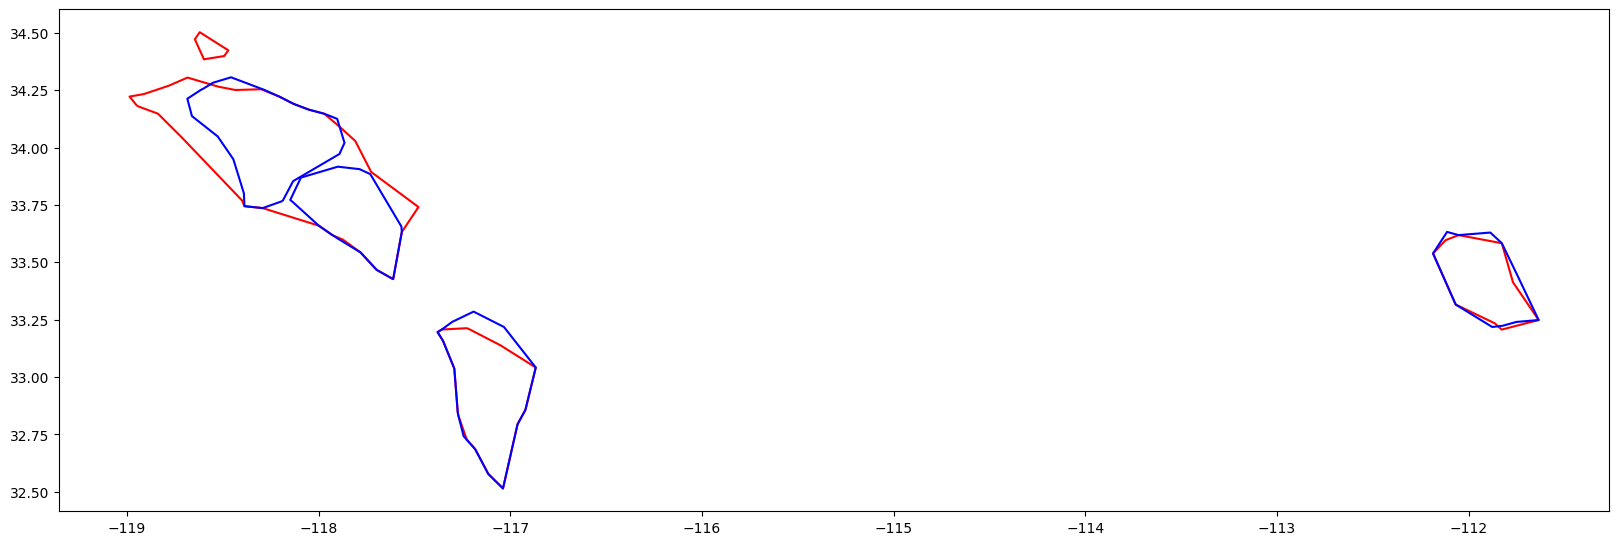

In [221]:
fig, ax = plt.subplots(figsize = (20,16)) 
olduber.geometry.boundary.plot(ax=ax, color='red')
curgdf.geometry.boundary.plot(ax=ax, color='blue')
# uber.geometry.boundary.plot(ax=ax, color='purple')

In [114]:
uber

,cluster,polygon,geometry
0,0,True,"POLYGON ((151.27901 -33.70100, 151.28900 -33.7..."
1,1,True,"POLYGON ((103.76200 1.48540, 103.84132 1.44053..."
2,2,True,"POLYGON ((77.40070 12.96350, 77.58460 13.08750..."
3,3,True,"POLYGON ((114.24371 22.26217, 114.17469 22.278..."
4,4,True,"POLYGON ((113.81224 22.67519, 113.83141 22.759..."
...,...,...,...
102,102,True,"POLYGON ((12.56670 56.00000, 12.56750 55.75890..."
103,103,True,"POLYGON ((12.04070 57.71400, 12.23090 57.69200..."
104,104,True,"POLYGON ((18.23330 59.55000, 18.34323 59.47070..."
105,105,True,"POLYGON ((24.93840 60.16990, 24.89050 60.15880..."


In [110]:
curover2.shape

(1,)

In [49]:
merged = merged = gpd.overlay(gdf1[gdf1.geom_type=='Polygon'], gdf2[gdf2.geom_type=='Polygon'], how='intersection')
merged.count()

cluster_1    86
polygon_1    86
cluster_2    86
polygon_2    86
geometry     86
dtype: int64

In [53]:
check = pd.merge(merged, gdf1, how='inner', left_on='cluster_1', right_on='cluster')
check['over']=check['geometry_x'].area/check['geometry_y'].area
check[check['over']<.1]

/tmp/ipykernel_1812071/3816193992.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  check['over']=check['geometry_x'].area/check['geometry_y'].area


,cluster_1,polygon_1,cluster_2,polygon_2,geometry_x,cluster,polygon,geometry_y,over
28,34,True,37,True,"POLYGON ((140.31528 35.41241, 140.30400 35.417...",34,True,"POLYGON ((140.33902 35.72419, 140.31528 35.412...",0.000037
35,36,True,43,True,"POLYGON ((-78.91780 35.91120, -78.88375 35.930...",36,True,"POLYGON ((-78.84580 35.62630, -78.90770 35.733...",0.003644


In [39]:
merged.area/gdf1.area

/tmp/ipykernel_1812071/481086858.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged.area/gdf1.area


0      0.623129
1      0.988565
2      0.624811
3      0.927244
4      0.790763
         ...   
102         NaN
103         NaN
104         NaN
105         NaN
106         NaN
Length: 107, dtype: float64

In [44]:
merged.area/gdf2.area

/tmp/ipykernel_1812071/677236017.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged.area/gdf2.area


0       0.648379
1       0.644328
2       0.959375
3       0.200845
4      19.688541
         ...    
104          NaN
105          NaN
106          NaN
107          NaN
108          NaN
Length: 109, dtype: float64

In [3]:
# merged.explore(column='cluster_1')

In [36]:
for index, row in merged.iterrows():
    id1 = row['cluster_1']
    id2 = row['cluster_2']
    if (math.isnan(id1)==False and math.isnan(id2)==False) :
        print(id1, id2, math.isnan(id1), math.isnan(id2))
        

0.0 0.0 False False
1.0 1.0 False False
2.0 2.0 False False
3.0 3.0 False False
4.0 3.0 False False
5.0 6.0 False False
6.0 9.0 False False
7.0 10.0 False False
8.0 11.0 False False
9.0 12.0 False False
10.0 13.0 False False
12.0 14.0 False False
13.0 15.0 False False
14.0 17.0 False False
15.0 18.0 False False
16.0 19.0 False False
17.0 21.0 False False
18.0 22.0 False False
19.0 24.0 False False
19.0 26.0 False False
20.0 23.0 False False
21.0 25.0 False False
23.0 30.0 False False
27.0 30.0 False False
25.0 33.0 False False
28.0 33.0 False False
32.0 33.0 False False
34.0 33.0 False False
41.0 33.0 False False
29.0 34.0 False False
30.0 36.0 False False
31.0 35.0 False False
34.0 37.0 False False
35.0 38.0 False False
36.0 40.0 False False
36.0 43.0 False False
37.0 41.0 False False
38.0 44.0 False False
39.0 45.0 False False
43.0 45.0 False False
44.0 45.0 False False
40.0 46.0 False False
42.0 47.0 False False
45.0 50.0 False False
47.0 52.0 False False
50.0 54.0 False False
52.0 

In [37]:
# merged.explore(column='cluster_1', cmap='rainbow')

# Compare shapes

In [161]:
df0.area

0    2.614865
1    2.593232
2    2.371477
dtype: float64

In [162]:
df1.area

0    2.361822
1    2.282452
2    2.176870
dtype: float64

In [163]:
df2.area

0    2.022711
1    1.900095
2    1.794160
dtype: float64

In [166]:
merged = gpd.overlay(df0, df1, how='intersection')
merged.area/df0.area

0    0.903229
1    0.880157
2    0.917938
dtype: float64

In [167]:
merged = gpd.overlay(df0, df2, how='intersection')
merged.area/df0.area

0    0.773543
1    0.732713
2    0.756558
dtype: float64

In [168]:
df2.area/df0.area

0    0.773543
1    0.732713
2    0.756558
dtype: float64

# Unions

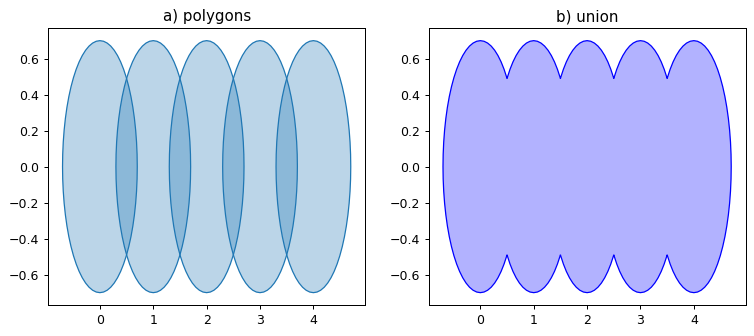

In [2]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.plotting import plot_polygon

# from figures import SIZE, BLUE, GRAY, set_limits

polygons = [Point(i, 0).buffer(0.7) for i in range(5)]

fig = plt.figure(1, figsize=[10,4], dpi=90)

# 1
ax = fig.add_subplot(121)

for ob in polygons:
    plot_polygon(ob, ax=ax, add_points=False)

ax.set_title('a) polygons')

# set_limits(ax, -2, 6, -2, 2)

#2
ax = fig.add_subplot(122)

u = unary_union(polygons)
plot_polygon(u, ax=ax, add_points=False, color='blue')

ax.set_title('b) union')

# set_limits(ax, -2, 6, -2, 2)

plt.show()

In [16]:
print(u)

POLYGON ((0.4440752989145518 -0.5411073173539158, 0.3888991631137216 -0.5820287286117817, 0.3299777157781984 -0.6173448850438484, 0.2678784026555628 -0.6467156727579007, 0.2031992740781236 -0.6698582350125463, 0.1365632254112898 -0.6865496962822613, 0.0686119982306925 -0.6966293086705377, 0 -0.7, -0.0686119982306924 -0.6966293086705379, -0.1365632254112897 -0.6865496962822613, -0.2031992740781235 -0.6698582350125463, -0.2678784026555628 -0.6467156727579007, -0.3299777157781983 -0.6173448850438485, -0.3888991631137214 -0.5820287286117818, -0.4440752989145517 -0.5411073173539159, -0.4949747468305832 -0.4949747468305833, -0.5411073173539158 -0.4440752989145518, -0.5820287286117817 -0.3888991631137215, -0.6173448850438484 -0.3299777157781985, -0.6467156727579007 -0.2678784026555629, -0.6698582350125462 -0.2031992740781237, -0.6865496962822613 -0.13656322541129, -0.6966293086705377 -0.0686119982306926, -0.7 -0.0000000000000001, -0.6966293086705379 0.0686119982306924, -0.6865496962822613 0.1

In [3]:
%pip install shapely --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.3 MB 7.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install figures --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
